## MH-McMC convergence

The code implements the Metropolis-Hastings algorithm for Bayesian inference of a normal mean with conjugate prior, exploring different proposal widths (variance values).

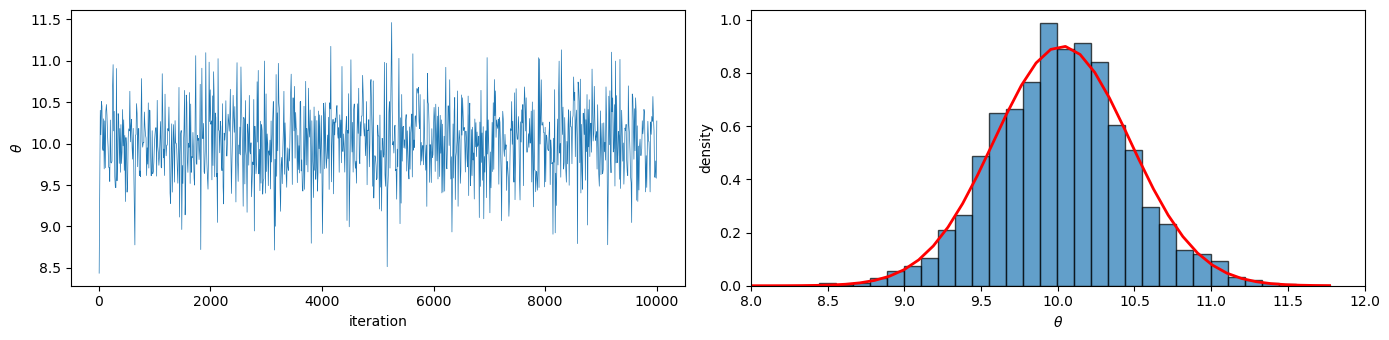

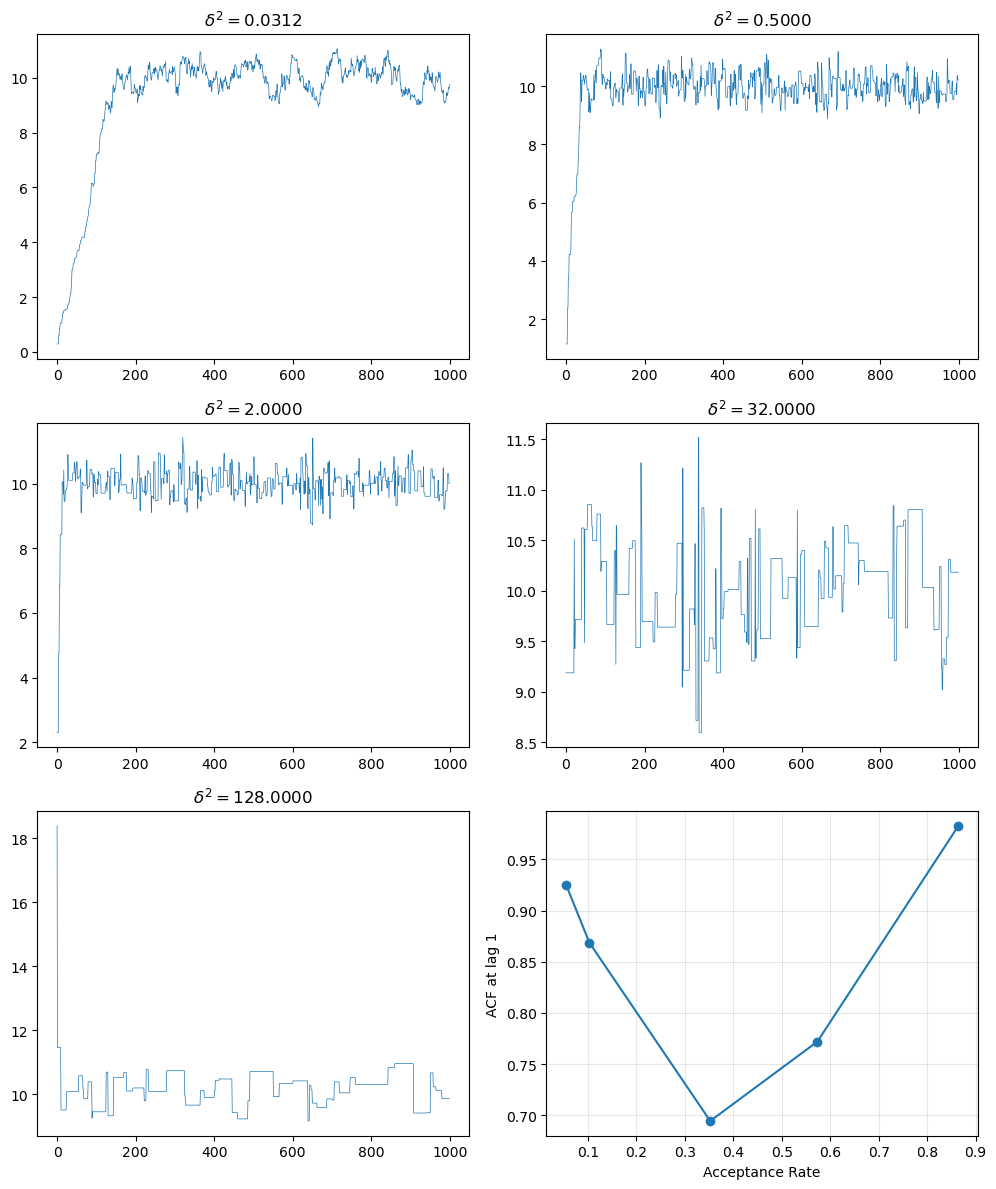

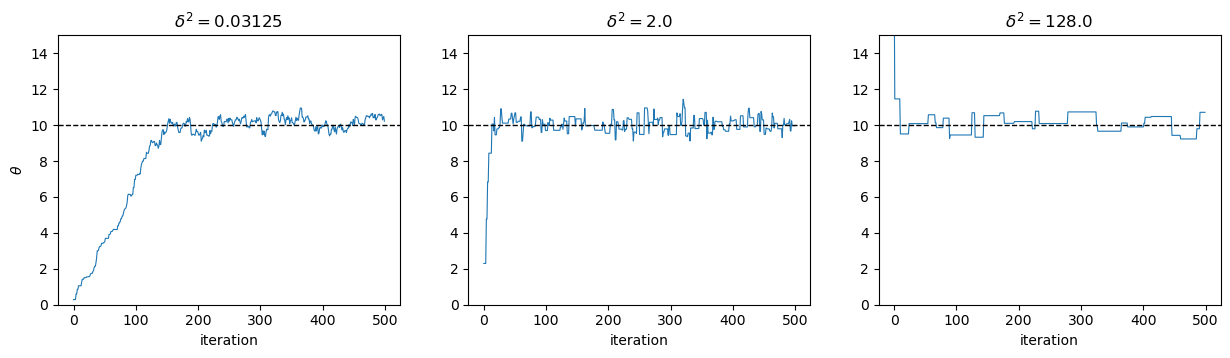

Posterior mean (analytical): 10.0275
Posterior variance (analytical): 0.1961
Acceptance rates: [0.8642, 0.5733, 0.3523, 0.1031, 0.0547]
ACF: [0.9826, 0.7719, 0.6944, 0.8685, 0.9254]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#### MH algorithm for one-sample normal problem

## Setup
s2 = 1
t2 = 10
mu = 5
np.random.seed(1)
n = 5
#y = np.round(np.random.normal(10, 1, n), 2)
y = np.array([9.37, 10.18, 9.16, 11.60, 10.33])
mu_n = (np.mean(y) * n / s2 + mu / t2) / (n / s2 + 1 / t2)
t2_n = 1 / (n / s2 + 1 / t2)

## MCMC
s2 = 1
t2 = 10
mu = 5
y = np.array([9.37, 10.18, 9.16, 11.60, 10.33])
theta = 0
delta = 2
S = 10000
THETA = []
np.random.seed(1)

for s in range(S):
    theta_star = np.random.normal(theta, np.sqrt(delta))
    
    log_r = (np.sum(norm.logpdf(y, theta_star, np.sqrt(s2))) + 
             norm.logpdf(theta_star, mu, np.sqrt(t2))) - \
            (np.sum(norm.logpdf(y, theta, np.sqrt(s2))) + 
             norm.logpdf(theta, mu, np.sqrt(t2)))
    
    if np.log(np.random.uniform()) < log_r:
        theta = theta_star
    
    THETA.append(theta)

THETA = np.array(THETA)

####
fig, axes = plt.subplots(1, 2, figsize=(14, 3.5))

skeep = np.arange(9, S, 10)  # Every 10th sample starting from index 9
axes[0].plot(skeep, THETA[skeep], linewidth=0.5)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel(r'$\theta$')

axes[1].hist(THETA[50:], bins=30, density=True, edgecolor='black', alpha=0.7)
axes[1].set_xlabel(r'$\theta$')
axes[1].set_ylabel('density')
th = np.linspace(THETA.min(), THETA.max(), 100)
axes[1].plot(th, norm.pdf(th, mu_n, np.sqrt(t2_n)), 'r-', linewidth=2)
axes[1].set_xlim(8,12)

plt.tight_layout()
plt.show()

#### MH algorithm with different proposal distributions
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

ACR = []
ACF = []
THETAA = []
# vary the proposal width, delta^2,  and sample
for idx, delta2 in enumerate(2.0**np.array([-5, -1, 1, 5, 7])):
    np.random.seed(1)
    THETA = []
    S = 10000
    theta = 0
    acs = 0
    
    for s in range(S):
        theta_star = np.random.normal(theta, np.sqrt(delta2))
        log_r = (np.sum(norm.logpdf(y, theta_star, np.sqrt(s2)) - 
                       norm.logpdf(y, theta, np.sqrt(s2))) +
                norm.logpdf(theta_star, mu, np.sqrt(t2)) - 
                norm.logpdf(theta, mu, np.sqrt(t2)))
        
        if np.log(np.random.uniform()) < log_r:
            theta = theta_star
            acs += 1
        
        THETA.append(theta)
    
    THETA = np.array(THETA)
    axes[idx].plot(THETA[:1000], linewidth=0.5)
    axes[idx].set_title(rf'$\delta^2 = {delta2:.4f}$')#, fontsize=12)
    ACR.append(acs / S)
    # Compute autocorrelation at lag 1
    acf_val = np.corrcoef(THETA[:-1], THETA[1:])[0, 1]
    ACF.append(acf_val)
    THETAA.append(THETA)

# Plot ACR vs ACF in the last subplot
axes[5].plot(ACR, ACF, 'o-')
axes[5].set_xlabel('Acceptance Rate')
axes[5].set_ylabel('ACF at lag 1')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

THETAA = np.array(THETAA).T  # Transpose to have iterations as rows

#### zoom in on first 500 samples
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
expo = np.array([-5, -1, 1, 5, 7])
for idx, k in enumerate([0, 2, 4]):
    s = 2.0**expo[k]
    axes[idx].plot(THETAA[:500, k], linewidth=0.8)
    axes[idx].set_xlabel('iteration')
    if idx == 0:
        axes[idx].set_ylabel(r'$\theta$')
    #axes[idx].set_ylim([THETAA.min(), THETAA.max()]) 
    axes[idx].set_ylim(0,15)
    axes[idx].axhline(y=mu_n, color='black', linestyle='--', linewidth=1)
    axes[idx].set_title(rf'$\delta^2 = {s}$')#, fontsize=12)

#plt.tight_layout()
plt.show()

# Cumulative mean
THCM = np.cumsum(THETAA, axis=0)
THCM = THCM / np.arange(1, THCM.shape[0] + 1)[:, np.newaxis]

print(f"Posterior mean (analytical): {mu_n:.4f}")
print(f"Posterior variance (analytical): {t2_n:.4f}")
print(f"Acceptance rates: {ACR}")
#print(f"Autocorrelations at lag 1: {ACF:.4f}")
formatted = ', '.join([f"{x:.4f}" for x in ACF])
print(f"ACF: [{formatted}]")

### Conclusions

The lag-1 autocorrelations for the above values of $\delta$ are 
	$$
	 (0.98,\, 0.77,\, 0.69,\, 0.87, \, 0.93)
	$$
and the optimal value is obtained for $\delta^2 = 2.$ This can be understood from the results for $\delta^2 = 1/32,\,2,$ and $64$ plotted above. We observe that,

1. For a small proposal variance,  $\delta^2=1/32$ (left plot), the candidate value $\theta^*$ will be close to $\theta^{(t)}$ which implies that $r$ will be approximately equal to one for most of the proposed values. It turns out that  $\theta^{*}$ is accepted as $\theta^{(t+1)}$ in $87\%$ of the iterations. This high acceptance rate guarantees that the chain moves, but these moves are always small and the convergence of the Markov chain is relatively slow.
2. For a large proposal variance,  $\delta^2=64$ (right plot), the chain moves rapidly to the mode, but remains stuck at a constant value over long periods. Since the variance is large, the value of $\theta^{*}$ is mostly far from the posterior mode and proposals are only accepted in $5\%$ of the iterations, so  $\theta^{(t+1)}$ is set equal to $\theta^{(t)}$ in $95\%$ of the iterations. This results in a highly correlated Markov chain.
3. The middle value, $\delta^2=2,$  is the sweet spot here--we have rapid convergence, minimal autocorrelation, and good mixing.